In [1]:
import json
import pickle
import io
import pandas as pd
from dataclasses import asdict
from backdoors import data, patterns, poison, utils, checkpoint_dir
from backdoors.data import load_cifar10, Data
import numpy as np
import matplotlib.pyplot as plt
import einops
import jax
from jax import numpy as jnp
from flax.training import train_state
import optax
import chex
import flax
from flax import linen as nn
from typing import Tuple
import matplotlib.pyplot as plt
import sympy
from jax import random
from collections import namedtuple
from time import time

import orbax.checkpoint
import os
from pathlib import Path

from backdoors import module_path, checkpoint_dir, train, paths
from backdoors.train import TrainState, Metrics, model, tx, \
    accuracy, train_step, init_train_state
from backdoors.models import CNN
from meta_transformer.data import load_pair_of_models, data_iterator
from tqdm import tqdm


checkpointer = orbax.checkpoint.PyTreeCheckpointer()

BATCH_SIZE = 64
NUM_EPOCHS = 5

#train_data, _ = load_cifar10()
#cifar10_train, cifar10_test = load_cifar10()

/home/lauro/.virtualenvs/meta-models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# load run infos
CLEAN_CHECKPOINT_DIR = paths.PRIMARY_CLEAN
BACKDOOR_CHECKPOINT_DIR = paths.PRIMARY_BACKDOOR / "simple_pattern"


all_infos = []
for i in range(10000):
    infopath = CLEAN_CHECKPOINT_DIR / str(i) / "info.json"
    info = json.loads(infopath.read_text())
    all_infos.append(info)


# merge dicts
all_infos = {k: [d[k] for d in all_infos] for k in all_infos[0]}

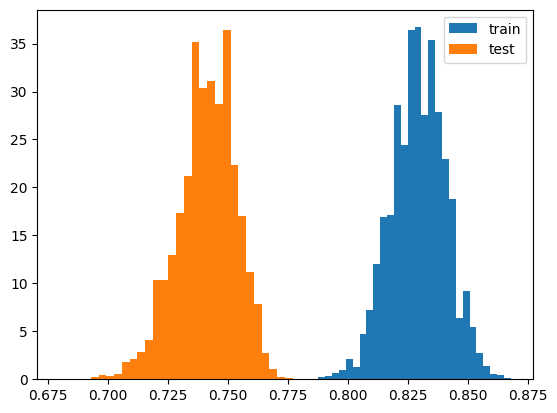

In [19]:
plt.hist(all_infos["train_accuracy"], bins=30, density=True, label="train")
plt.hist(all_infos["test_accuracy"], bins=30, density=True, label="test")
plt.legend()

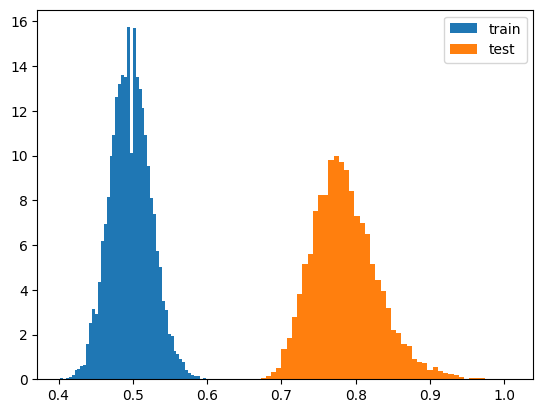

In [18]:
plt.hist(all_infos["train_loss"], bins=30, density=True, label="train")
plt.hist(all_infos["test_loss"], bins=30, density=True, label="test")
plt.legend()

In [ ]:
raise

In [ ]:
CLEAN_CHECKPOINT_DIR = paths.PRIMARY_CLEAN
BACKDOOR_CHECKPOINT_DIR = paths.PRIMARY_BACKDOOR / "simple_pattern"


def get_clean_params(idx: int):
    for entry in os.scandir(CLEAN_CHECKPOINT_DIR):
        if entry.name.startswith("checkpoints"):
            idxs = entry.name.split("_")[-1].split(".")[0]
            with open(entry.path, "rb") as f:
                return pickle.load(f)


def get_backdoored_params():
    for entry in os.scandir(BACKDOOR_CHECKPOINT_DIR):
        if entry.name.startswith("checkpoints"):
            idxs = entry.name.split("_")[-1].split(".")[0]
            with open(entry.path, "rb") as f:
                return pickle.load(f)


In [ ]:
params, infos = get_clean_params(0)

In [ ]:
infos

({'test_accuracy': 0.5952,
  'test_loss': 1.1559,
  'train_accuracy': 0.5914,
  'train_loss': 1.1244},
 {'test_accuracy': 0.586,
  'test_loss': 1.1584,
  'train_accuracy': 0.5914,
  'train_loss': 1.172},
 {'test_accuracy': 0.6075,
  'test_loss': 1.0916,
  'train_accuracy': 0.6133,
  'train_loss': 1.0938})

In [ ]:
model = CNN()
params = model.init(rng, jnp.ones((1, 32, 32, 3)))["params"]
jax.tree_map(lambda x: x.shape, params)

{'Conv_0': {'bias': (32,), 'kernel': (3, 3, 3, 32)},
 'Conv_1': {'bias': (32,), 'kernel': (3, 3, 32, 32)},
 'Conv_2': {'bias': (64,), 'kernel': (3, 3, 32, 64)},
 'Conv_3': {'bias': (64,), 'kernel': (3, 3, 64, 64)},
 'Conv_4': {'bias': (128,), 'kernel': (3, 3, 64, 128)},
 'Conv_5': {'bias': (128,), 'kernel': (3, 3, 128, 128)},
 'Dense_6': {'bias': (10,), 'kernel': (128, 10)}}

In [ ]:
import zipfile
SAVEDIR = Path("temp.zip")
batch_dir = Path("batch")
with zipfile.ZipFile(SAVEDIR, "w") as zf:
    savepath = str(batch_dir / "params")
    with zf.open(savepath, "w") as f:
        p = jax.tree_map(lambda x: x.tolist(), params)
        f.write(json.dumps(p).encode())

In [ ]:
import zipfile
import pickle

SAVEDIR = Path("temp.zip")
batch_dir = Path("batch")
#with zipfile.ZipFile(SAVEDIR, "w") as zf:
#    savepath = str(batch_dir / "params")
#    with zf.open(savepath, "w") as f:
#        #p = jax.tree_map(lambda x: x.tolist(), params)
#        p = pickle.dumps(params)
#        f.write(json.dumps(p).encode())
with open("temp.pkl", "wb") as f:
    pickle.dump(params, f)

In [ ]:
with open("temp.pkl", "rb") as f:
    loaded_params = pickle.load(f)


In [ ]:
checkpointer.save("temp", params)

In [ ]:
json.dumps({"a": 1, "b": 2, "c": None})

'{"a": 1, "b": 2, "c": null}'

In [ ]:
params_plain = jax.tree_map(lambda arr: arr.tolist(), params)

In [ ]:
for k, v in params_plain.items():
    for kk, vv in v.items():
        print(k, kk, len(vv))

Conv_0 bias 32
Conv_0 kernel 3
Conv_1 bias 32
Conv_1 kernel 3
Conv_2 bias 64
Conv_2 kernel 3
Conv_3 bias 64
Conv_3 kernel 3
Conv_4 bias 128
Conv_4 kernel 3
Conv_5 bias 128
Conv_5 kernel 3
Dense_6 bias 10
Dense_6 kernel 128


In [ ]:
str(Path("test"))

'test'

In [ ]:
"test".encode("utf-8")

b'test'

In [ ]:
a = []
a.append(1,2)
a

TypeError: list.append() takes exactly one argument (2 given)

In [ ]:
params_plain.keys()

dict_keys(['Conv_0', 'Conv_1', 'Conv_2', 'Conv_3', 'Conv_4', 'Conv_5', 'Dense_6'])

In [ ]:
model.apply({"params": params}, jnp.ones((1, 32, 32, 3)))

Array([[ 0.17627773, -0.00739185,  0.37206712,  0.02501557,  0.5720889 ,
        -0.12718616, -0.00155175,  0.11558752, -0.11277112, -0.16591665]],      dtype=float32)

In [ ]:
z = jax.xla_computation(model.apply)({"params": params}, jnp.ones((1, 32, 32, 3)))

In [ ]:
z[1]

ShapeDtypeStruct(shape=(1, 10), dtype=float32)

In [ ]:
with open("test", "w") as f:
    f.write(z.as_hlo_dot_graph())